# Defining `Function`s on `SubDomain`s

In many contexts, fields are required over only a subset of the computational `Grid`. In Devito, such fields can be implemented via the `Function`s on `SubDomain`s API, allocating arrays only over the required region of the `Grid`, thereby reducing memory consumption. This functionality is seamlessly compatible with MPI, as with any other Devito object, and these arrays are aligned with the domain decomposition under the hood.

We will begin with some necessary imports.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

from IPython.display import HTML

from devito import SubDomain, Grid, Function, Eq, Operator, \
    SparseFunction, ConditionalDimension, TimeFunction, solve
from examples.seismic import TimeAxis, RickerSource, Model

## Basic usage

As usual, we define a subdomain template by subclassing `SubDomain` and overriding the `define` method. The `'middle'` subdomain we have defined in this case excludes two points from each side of the domain in each dimension.

In [2]:
class Middle(SubDomain):
    name = 'middle'

    def define(self, dimensions):
        return {d: ('middle', 2, 2) for d in dimensions}

We then create a `Grid` and create an instance of `Middle`. We can then use this subdomain as the computational grid when defining a `Function`. For comparison, we also create a `Function` defined on a `Grid`.

In [3]:
grid0 = Grid(shape=(11, 11), extent=(10., 10.))

middle = Middle(grid=grid0)

f = Function(name='f', grid=middle)  # Define Function on SubDomain
g = Function(name='g', grid=grid0)

Inspecting the `shape` of `f`, it is apparent that it is smaller than the `Grid` on which `middle` is defined, instead sharing its shape with `middle`.

In [4]:
f.shape

(7, 7)

Furthermore, `f` has the dimensions of the `SubDomain` rather than the `Grid`.

In [5]:
f.dimensions

(ix, iy)

By contrast, when inspecting `g`, we observe that it's shape and dimensions match those of the `Grid`.

In [6]:
g.shape

(11, 11)

In [7]:
g.dimensions

(x, y)

To contrast the behaviour of a `Function` defined on a `SubDomain` to one defined on a `Grid`, we implement a trivial `Operator`, setting both `f` and `g` equal to one within the `SubDomain` `middle`.

In [8]:
# Equations operating on Functions defined on SubDomains must be applied over
# the SubDomain, or a SubDomain representing some subset thereof.
eqf = Eq(f, 1, subdomain=middle)
eqg = Eq(g, 1, subdomain=middle)

Operator([eqf, eqg])()

NUMA domain count autodetection failed
Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000243, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Examining `f.data`, we see that it has been entirely set to one by the `Operator`. By contrast, `g.data` is only set to one in the central region.

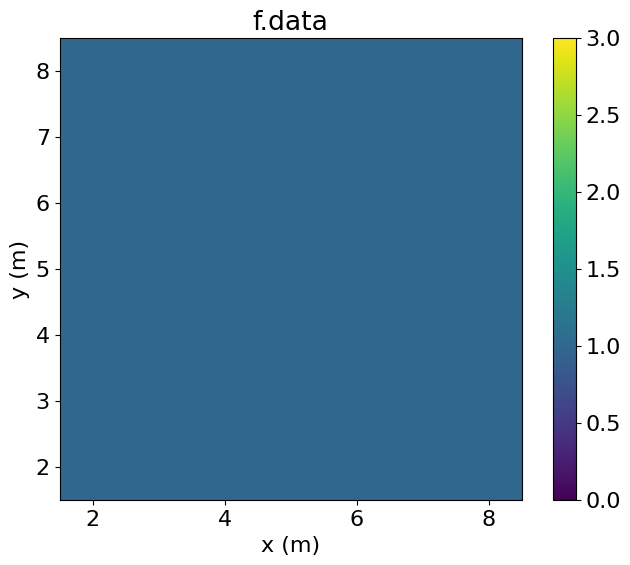

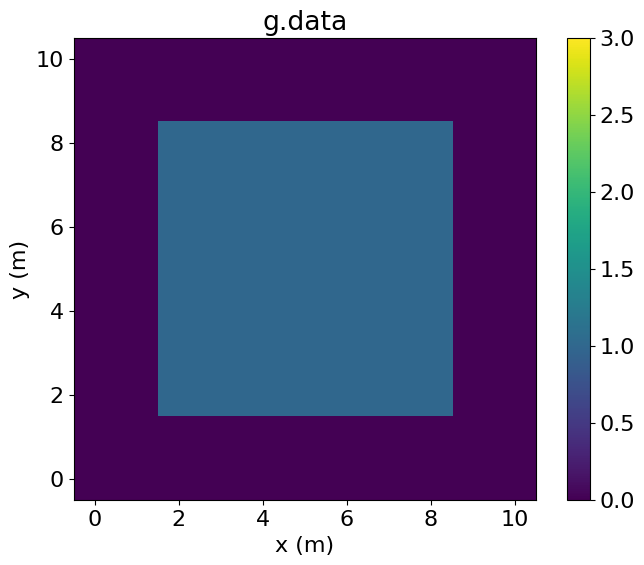

In [9]:
# TODO: Make a plotter
plt.imshow(f.data.T, vmin=0, vmax=3, origin='lower', extent=(1.5, 8.5, 1.5, 8.5))
plt.colorbar()
plt.title("f.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

plt.imshow(g.data.T, vmin=0, vmax=3, origin='lower', extent=(-0.5, 10.5, -0.5, 10.5))
plt.colorbar()
plt.title("g.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

When operating on a `Function` defined on a `SubDomain`, Devito keeps track of the alignment of the fields relative to the base `Grid`. As such, we can perform operations combining `Function`s defined on `SubDomain`s with those defined on the `Grid`. For example, we can add `f` to `g` as follows:

In [10]:
eqfg = Eq(g, g + f, subdomain=middle)
Operator(eqfg)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=7e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Plotting `g.data`, we see that the central region, corresponding to `middle`, has been incremented by the value of `f`.

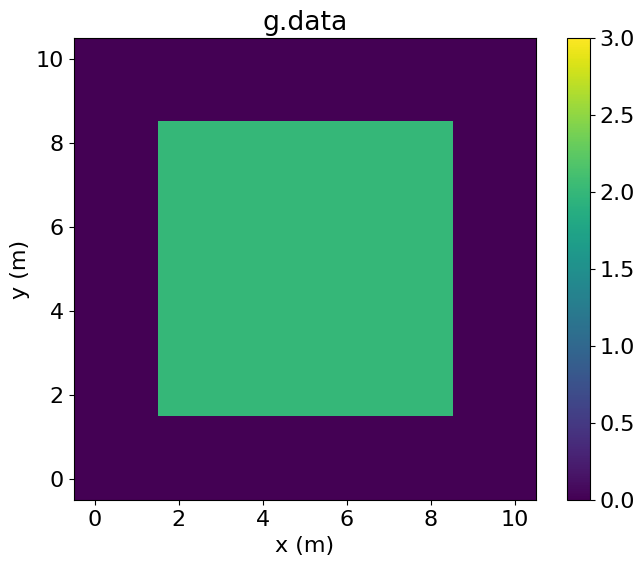

In [11]:
plt.imshow(g.data.T, vmin=0, vmax=3, origin='lower', extent=(-0.5, 10.5, -0.5, 10.5))
plt.colorbar()
plt.title("g.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

Note that we need not only iterate over the `SubDomain` on which our `Function` is defined. One can also iterate over any subset of this `SubDomain`. In this case, we define a new `Left` domain, alongside `Intersection`, which is the intersection of `Left` and `Middle`. We then define another `Function` `h` on `left`.

In [12]:
class Left(SubDomain):
    name = 'left'

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', 6), y: y}


class Intersection(SubDomain):
    # Intersection of Left and Middle
    name = 'intersection'

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 2, 5), y: ('middle', 2, 2)}


# Create the SubDomain instances
left = Left(grid=grid0)
intersection = Intersection(grid=grid0)

h = Function(name='h', grid=left)
h.data[:] = 1

Printing `h.shape`, we see that its size is also smaller than that of the `Grid`.

In [13]:
h.shape

(6, 11)

We can then define equations which act over the intersection of `Middle` and `Left`. These equations can operate on any of the `Function`s defined thus far.

In [14]:
# Add h (defined on Left) to g (defined on Grid) over Intersection, and store result in g
eqgh = Eq(g, g + h, subdomain=intersection)
# Add h (defined on Left) to f (defined on Middle) over Intersection, and store result in f
eqfh = Eq(f, f + h, subdomain=intersection)

Operator([eqgh, eqfh])()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=9.3e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Plotting both `g` and `f`, we observe that both have been incremented by one (the value stored in`h`) over the intersection.

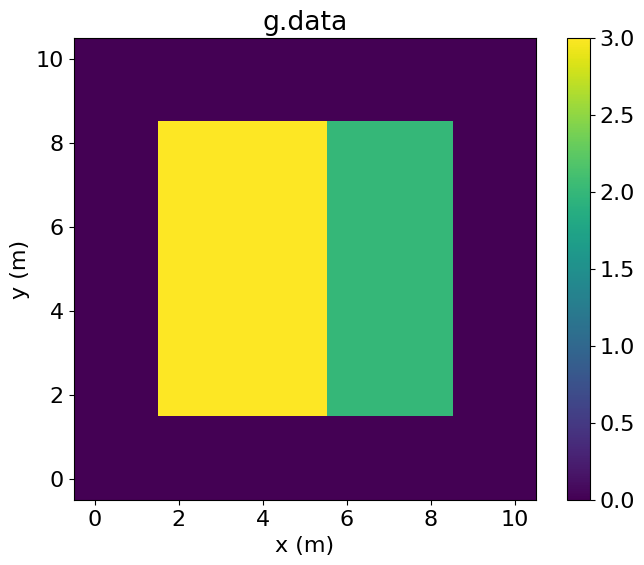

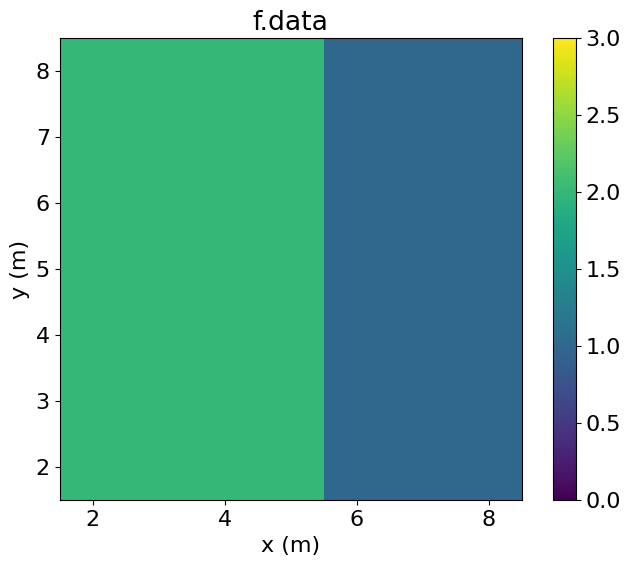

In [15]:
plt.imshow(g.data.T, vmin=0, vmax=3, origin='lower', extent=(-0.5, 10.5, -0.5, 10.5))
plt.colorbar()
plt.title("g.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

plt.imshow(f.data.T, vmin=0, vmax=3, origin='lower', extent=(1.5, 8.5, 1.5, 8.5))
plt.colorbar()
plt.title("f.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

Finally, we can also take values from a `Function` defined on the `Grid`, operate on them, and store them in a `Function` defined on a `SubDomain`.

In [16]:
eqgf = Eq(f, g, subdomain=middle)
Operator(eqgf)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000116, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Note that `f` now contains the same values as the central region of `g`.

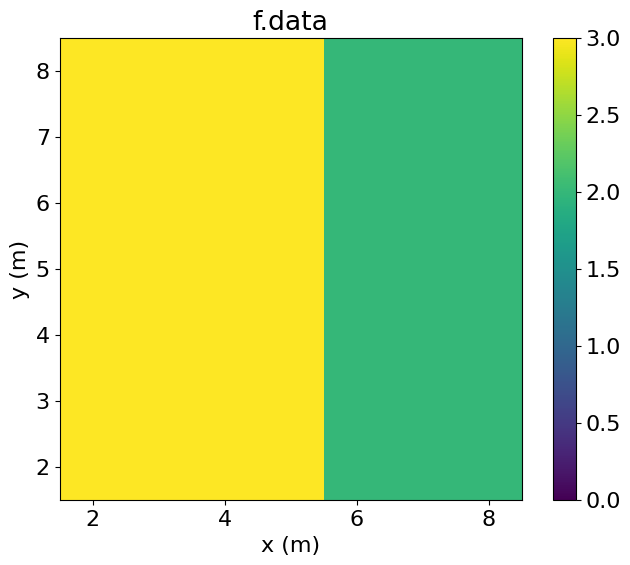

In [17]:
plt.imshow(f.data.T, vmin=0, vmax=3, origin='lower', extent=(1.5, 8.5, 1.5, 8.5))
plt.colorbar()
plt.title("f.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

## Sparse operations

Similarly, one can perform sparse operations such as injection into or interpolation off of `Function`s defined on `SubDomain`s. This is performed as per the usual interface. Note however that the operation will be windowed to the `SubDomain`, not the `Grid`, even if it involves the interpolation of an expression featuring both `Function`s defined on a `SubDomain` and those defined on a `Grid`. This is because such an operation would be undefined outside a `SubDomain`.

We begin by constructing a `SparseFunction`.

In [18]:
srcrec = SparseFunction(name='srcrec', grid=grid0, npoint=1)
srcrec.coordinates.data[:] = np.array([[3., 3.]])

A simple interpolation operator is constructed as follows:

In [19]:
rec = srcrec.interpolate(expr=f)
Operator(rec)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=6.4e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Printing `srcrec.data`, it is apparent that it now contains the value interpolated off of `f`.

In [20]:
srcrec.data

Data([3.], dtype=float32)

As aforementioned, one can also interpolate an expression featuring `Function`s defined on both the `Grid` and a `SubDomain. This can be straightforwardly achieved as follows:

In [21]:
rec = srcrec.interpolate(expr=f+g)
Operator(rec)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000116, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Note that since one of our previous operators set `f` equal to `g` over `Middle`, `srcrec.data` is now equal to 6.

In [22]:
srcrec.data

Data([6.], dtype=float32)

We can also inject into a `Function` defined on a `SubDomain`.

In [23]:
src = srcrec.inject(field=h, expr=1)
Operator(src)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.8e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Plotting `h.data`, we see that a value of 1 has been injected. It is also apparent that this injection is aligned with the global grid.

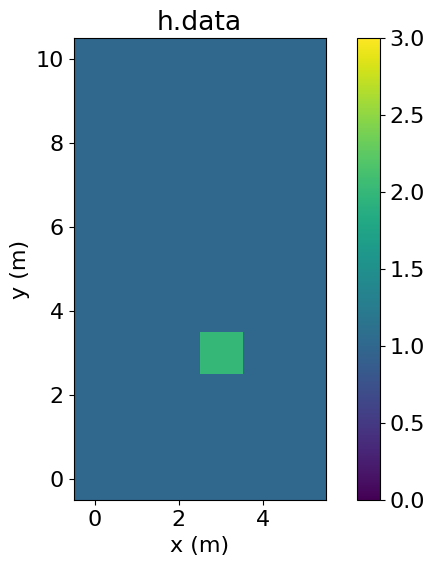

In [24]:
plt.imshow(h.data.T, vmin=0, vmax=3, origin='lower', extent=(-0.5, 5.5, -0.5, 10.5))
plt.colorbar()
plt.title("h.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

## Snapshotting on a subset of a domain

We will now consider a practical application of this functionality. In many applications, it is necessary to capture snapshots of a simulation as it progresses. However, such snapshots may not be needed over the entirety of the domain. We can use a `Function` defined on the subset of the domain that we aim to capture to minimize the size of the arrays allocated.

In this case, we will consider the snapshotting of a seismic wavefield. In imaging workflows, there is no need to calculate an imaging condition in the water column, and thus no need to store snapshots of this portion of the domain.

In [25]:
origin = (0., 0.)
shape = (201, 201)
spacing = (5., 5.)
extent = tuple((sh-1)*sp for sh, sp in zip(shape, spacing))

# Layered model
vp = np.full(shape, 1.5)
for i in range(6):
    vp[:, 50+i*25:] += 0.3

Operator `initdamp` ran in 0.01 s


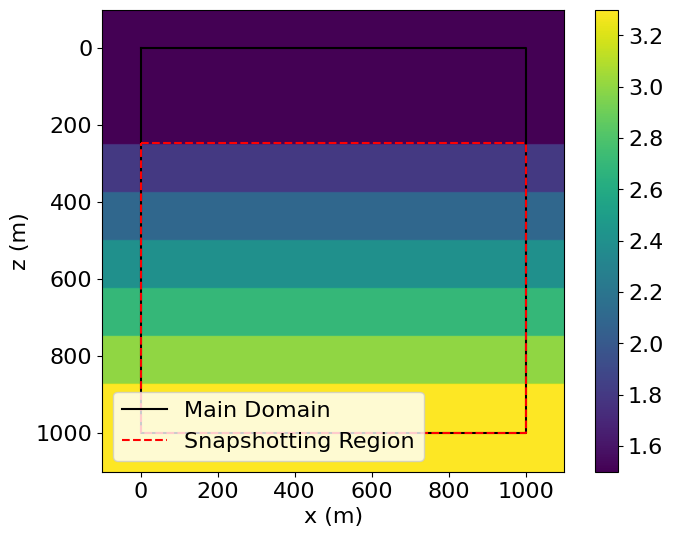

In [26]:
model = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=20, bcs="damp")

plt.imshow(model.vp.data.T, extent=(-100, 1100., 1100., -100.))
plt.plot((0, 1000, 1000, 0, 0), (0, 0, 1000, 1000, 0), 'k', label="Main Domain")
plt.plot((0, 1000, 1000, 0, 0), (245, 245, 1000, 1000, 245), 'r--', label="Snapshotting Region")
plt.legend(loc='lower left')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.show()

In [27]:
class SnapshotDomain(SubDomain):
    name = 'snapshot'

    def define(self, dimensions):
        x, y = dimensions
        # Exclude damping layers and water column
        return {x: ('middle', 20, 20), y: ('middle', 70, 20)}


snapshotdomain = SnapshotDomain(grid=model.grid)

Operator `Kernel` ran in 0.01 s


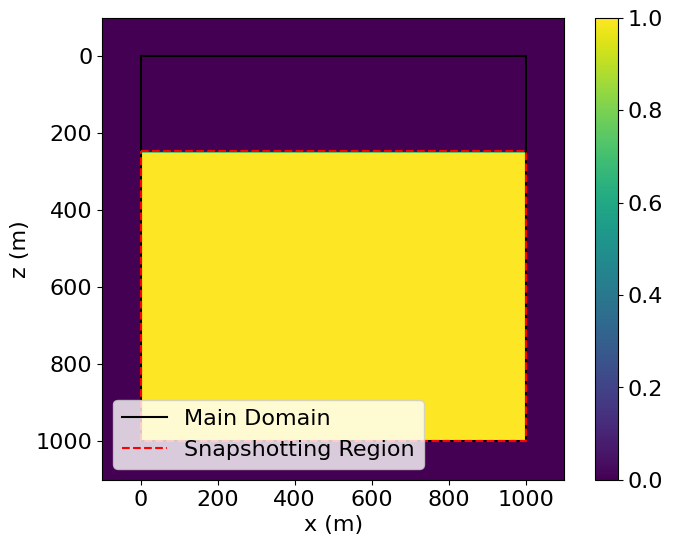

In [28]:
# Make a Function and set it equal to one to check the alignment of subdomain
testfunc = Function(name='testfunc', grid=model.grid)
Operator(Eq(testfunc, 1, subdomain=snapshotdomain))()

plt.imshow(testfunc.data.T, extent=(-100, 1100., 1100., -100.))
plt.plot((0, 1000, 1000, 0, 0), (0, 0, 1000, 1000, 0), 'k', label="Main Domain")
plt.plot((0, 1000, 1000, 0, 0), (245, 245, 1000, 1000, 245), 'r--', label="Snapshotting Region")
plt.legend(loc='lower left')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.show()

In [29]:
# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = 500.  # Simulation lasts tn milliseconds
dt = 0.8*model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 0.040  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)  

src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

In [30]:
nsnaps = 30
factor = round(nt/nsnaps)

time_subsampled = ConditionalDimension('t_sub', parent=model.grid.time_dim, factor=factor)

usave = TimeFunction(name='usave', grid=snapshotdomain, time_order=2, space_order=2,
                     save=nsnaps, time_dim=time_subsampled)

# "Normal" snapshotting for comparison
usavegrid = TimeFunction(name='usavegrid', grid=model.grid, time_order=2, space_order=2,
                         save=nsnaps, time_dim=time_subsampled)

In [31]:
memreduction = round(float(100*(usavegrid.size - usave.size)/usavegrid.size), 2)

print(f"Using `Function`s on `SubDomain`s for this snapshot reduces memory requirements by {memreduction}%")

Using `Function`s on `SubDomain`s for this snapshot reduces memory requirements by 47.06%


In [32]:
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8)

pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src)

# Save both "normal" and subdomain snapshots for comparison
op = Operator([stencil] + src_term + [Eq(usave, u, subdomain=snapshotdomain), Eq(usavegrid, u)])
op.apply(t_M=nt-2, dt=dt)

Operator `Kernel` ran in 0.11 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.05748299999999991, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.04089299999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0020559999999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.0022789999999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

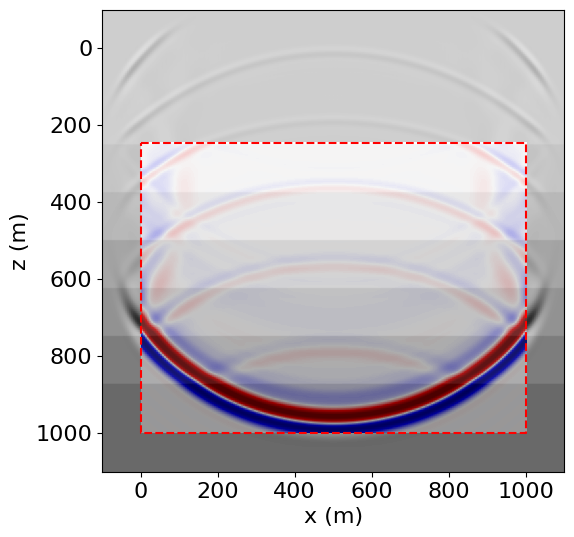

In [42]:
# TODO: Make this an animation

def plot_wavefield(f, fg, v, i):
    clip = 0.5
    vmax = clip*np.amax(np.abs(f.data))
    vmin = -vmax
    plt.imshow(fg.data[i].T, cmap="Greys", extent=(-100, 1100., 1100., -100.))
    plt.imshow(f.data[i].T, vmin=vmin, vmax=vmax, cmap='seismic',
               extent=(0., 1000., 1000., 245.))
    plt.imshow(v.data.T, cmap="Greys", extent=(-100, 1100., 1100., -100.), alpha=0.4)
    plt.plot((0, 1000, 1000, 0, 0), (245, 245, 1000, 1000, 245), 'r--', label="Snapshotting Region")
    plt.xlabel("x (m)")
    plt.ylabel("z (m)")
    plt.show()

plot_wavefield(usave, usavegrid, model.vp, 29)

In [47]:
def animate_wavefield(f, fg, v, interval=100):
    """
    Create an animation of the wavefield.

    Parameters:
      f        : Object containing wavefield data (assumed f.data is 3D with time as first dimension)
      fg       : Object containing foreground data (assumed fg.data is 3D with time as first dimension)
      v        : Object containing the constant velocity model (assumed v.data is 2D)
      interval : Delay between frames in milliseconds (default: 50)
    """
    # Determine color limits based on full dataset (so they remain constant throughout)
    clip = 0.5
    vmax = clip * np.amax(np.abs(f.data))
    vmin = -vmax

    # Create the figure and axis
    fig, ax = plt.subplots()

    # --- Draw static (background) elements ---
    # Velocity model (constant background)
    ax.imshow(v.data.T, cmap="Greys", extent=(-100, 1100, 1100, -100),
              alpha=0.4, zorder=3)
    # Snapshot region (red dashed line)
    ax.plot((0, 1000, 1000, 0, 0), (245, 245, 1000, 1000, 245),
            'r--', label="Snapshotting Region", zorder=4)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")

    # --- Draw time-dependent images ---
    # Initialize with the first frame (frame index 0)
    im_fg = ax.imshow(fg.data[0].T, vmin=vmin, vmax=vmax, cmap="Greys",
                      extent=(-100, 1100, 1100, -100), zorder=1)
    im_f  = ax.imshow(f.data[0].T, vmin=vmin, vmax=vmax, cmap='seismic',
                      extent=(0, 1000, 1000, 245), zorder=2)

    # Set axis limits
    ax.set_xlim(-100, 1100)
    ax.set_ylim(1100, -100)

    def update(frame):
        """Update the images for frame 'frame'."""
        # im_fg doesn't seem to update correctly
        im_fg.set_data(fg.data[frame].T)
        im_f.set_data(f.data[frame].T)
        return im_fg, im_f

    # Determine the total number of frames from the first dimension of f.data
    n_frames = f.data.shape[0]

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=interval, blit=True)
    plt.close()

    return ani

# Example usage:
# Assuming usave, usavegrid, and model.vp are already defined and have a .data attribute:
ani = animate_wavefield(usave, usavegrid, model.vp)

HTML(ani.to_html5_video())

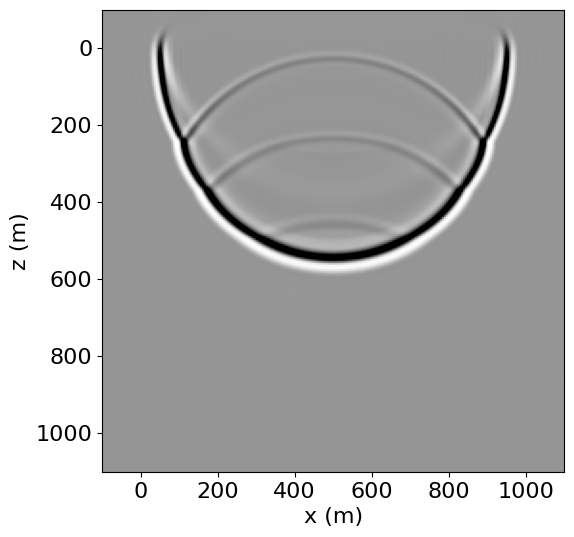

In [69]:
fig, ax = plt.subplots()

clip = 0.5
vmax = clip * np.amax(np.abs(usave.data))
vmin = -vmax

# --- Draw static (background) elements ---
# Velocity model (constant background)
# ax.imshow(v.data.T, cmap="Greys", extent=(-100, 1100, 1100, -100),
#           alpha=0.4, zorder=3)
# Snapshot region (red dashed line)
# ax.plot((0, 1000, 1000, 0, 0), (245, 245, 1000, 1000, 245),
#         'r--', label="Snapshotting Region", zorder=4)
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")

# --- Draw time-dependent images ---
# Initialize with the first frame (frame index 0)
im_fg = ax.imshow(usavegrid.data[0].T, vmin=vmin, vmax=vmax, cmap="Greys", extent=(-100, 1100, 1100, -100),
                  zorder=1)
# im_f  = ax.imshow(usave.data[0].T, vmin=vmin, vmax=vmax, cmap='seismic',
#                   extent=(0, 1000, 1000, 245), zorder=2)

im_fg.set_data(usavegrid.data[20].T)
# im_f.set_data(usave.data[20].T)

plt.show()

## Seafloor coupling

## Perfectly-matched layers